In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lrgsglib.core import *
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
data_path = Path('data')
fig_path = data_path / Path('figures')
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_dict = {}
int_label_pos_map = {}

for pat in patients_list:
    data_dict[pat] = {}
    #
    patnum = int(pat.split('_')[-1])
    patpath = mat_path / pat
    #
    ch_dat = pd.read_csv(patpath / f'Implant_pat_{patnum}.csv')
    ch_names = pd.read_csv(patpath / 'channel_labels.csv')
    #
    int_label_pos_map[pat] = ch_names.merge(ch_dat,on='label', how='left')
    df = int_label_pos_map[pat][['x', 'y', 'z']]
    df = df.apply(lambda s: s.str.replace(',', '.', regex=False).astype(float))
    #
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        try:
            # Load the .mat file using scipy.io.loadmat
            # This is the preferred method for loading .mat files
            tmp_mat = loadmat(str(mat_path / pat / f'{phase}'))
        except Exception as e:
            # If loading fails, fall back to h5py
            print(f'{type(e).__name__} loading {pat} {phase}: {e}. ',
                  f'Continuing with h5py', end='\r', flush=True)
            tmp_mat = {}
            f = h5py.File(mat_path / pat / f'{phase}.mat')
            for k, v in f.items():
                tmp_mat[k] = np.array(v)
            pass
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = data_dict[pat][phase]['data'].shape
        if tmp_shape[0] > tmp_shape[1]:
            # Transpose the data if the first dimension is bigger
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Extract the parameters from the loaded data
            # Check if 'Parameters' is in the loaded data
            # If not, skip to the next iteration
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

In [ ]:
pat = 'Pat_02'
filttime = 200

In [ ]:
corr_nets = {}
corr_nets_th = {}
corr_nets_unfilt = {}
for phase in phase_labels:
    print(f'Processing {pat} {phase}...', end='\r', flush=True)
    corr_nets[phase] = {}
    corr_nets_th[phase] = {}
    corr_nets_unfilt[phase] = {}
    for band_name, (low, high) in BRAIN_BANDS.items():
        # low, high = BRAIN_BANDS[band_name]
        try:
            sample_rate = data_dict[pat][phase]['fs']
            filter_order = data_dict[pat][phase]['filter_order']
            data = data_dict[pat][phase]['data'][:, :filttime]
            filt = bandpass_sos(data, low, high, sample_rate, int(filter_order))
            assert not np.allclose(filt, data, rtol=1e-5, atol=1e-8), \
                f'Band-pass output is indistinguishable from input in {band_name} band'
        except AssertionError as e:
            print(f'Band-pass output is indistinguishable from input in {band_name} band: {e}')
            continue
        C_filt_th = build_corr_network(filt, threshold=0)
        # C_filt = build_corr_network(filt, threshold=None, filter_type='abs')
        # G_filt = nx.from_numpy_array(C_filt)
        G_filt_th = nx.from_numpy_array(C_filt_th)
        # Compute threshold statistics
        Th, Einf, Pinf = compute_threshold_stats(G_filt_th)
        Pinf_diff = np.diff(Pinf)
        jumps = np.where(Pinf_diff != 0)[0]
        #
        C_tmp = build_corr_network(C_filt_th, threshold=Th[jumps[0]-1])
        G_tmp = nx.from_numpy_array(C_tmp)
        print(G_tmp.number_of_nodes())
        #
        corr_nets_th[phase][band_name] = C_tmp

117
117
117
117
117
117
117cessing Pat_02 taskLearn...
117
117
117
117
117
117cessing Pat_02 taskTest...
117
117
117
117
117
117cessing Pat_02 rsPost...
117
117
117
117
117


In [19]:
corr_nets

{'rsPre': {}, 'taskLearn': {}, 'taskTest': {}, 'rsPost': {}}

KeyError: 'delta'

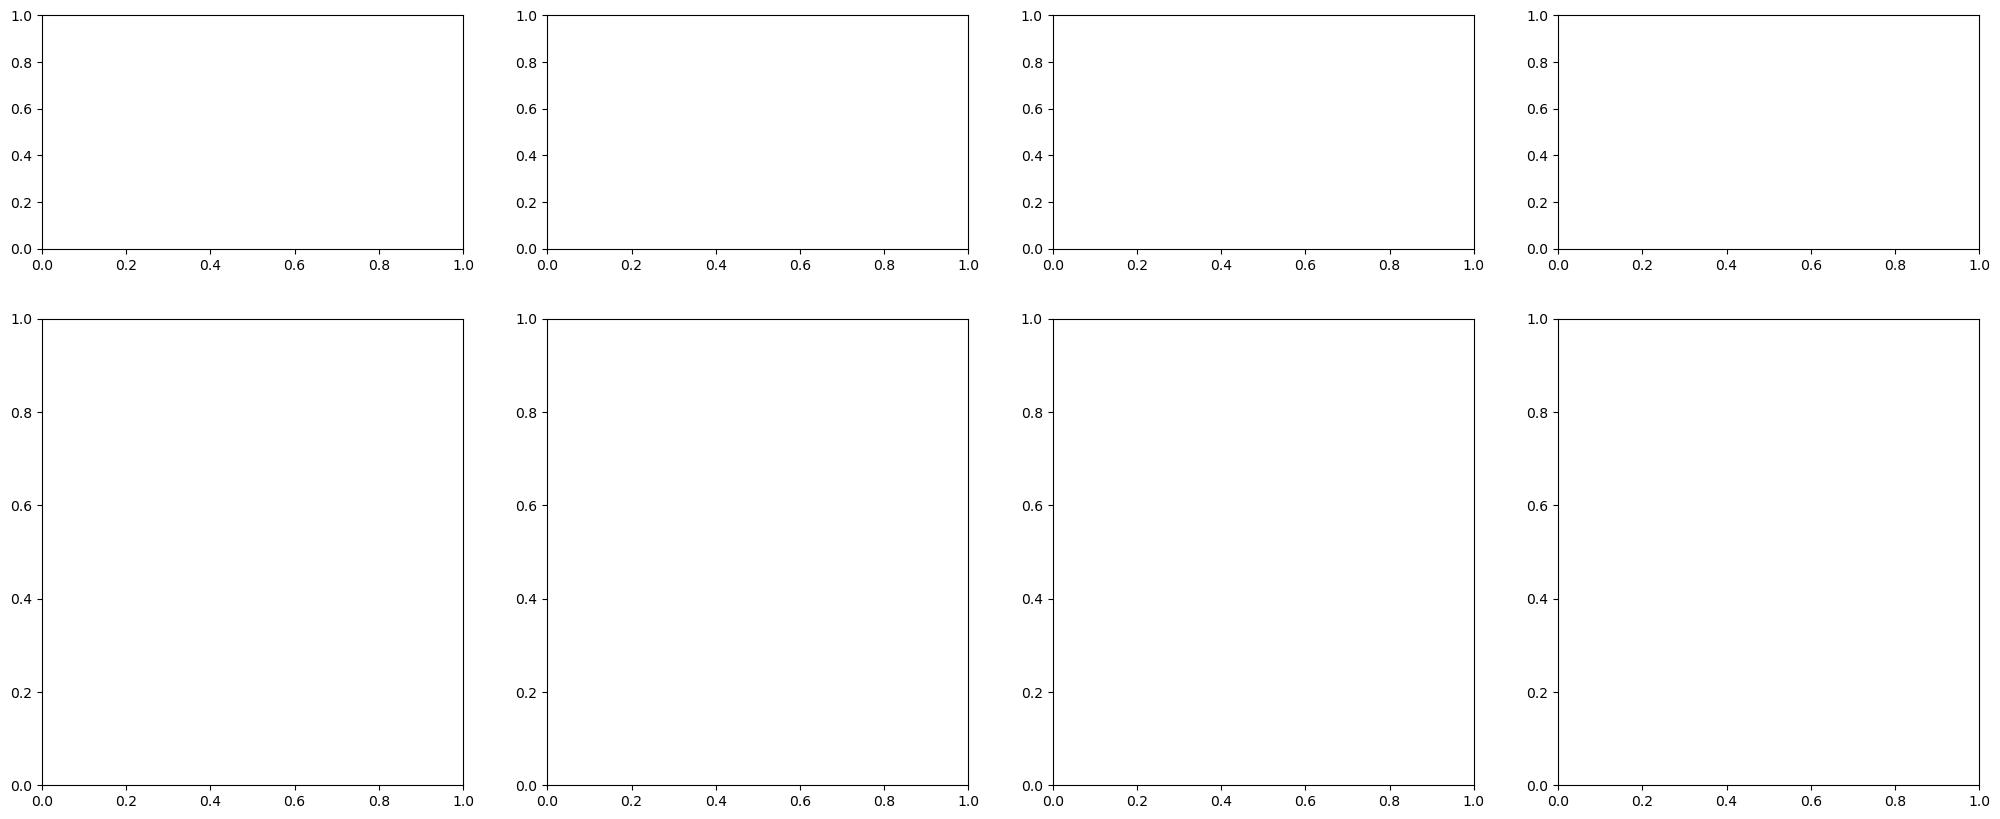

In [14]:
# band = 'low_gamma'
for band_name in BRAIN_BANDS.keys():
    fig, ax = plt.subplots(2, len(phase_labels), figsize=(25, 10), height_ratios=[1, 2])
    for i, phase in enumerate(phase_labels):
        Gcc = get_giant_component(nx.from_numpy_array(corr_nets[phase][band_name])) 
        net_ent = entropy(Gcc, t1=-3, t2=6)
        tau_scale = net_ent[-1]
        speC = net_ent[1]
        # laplacian-based distances
        spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)
        dists = squareform(Trho)
        linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')
        FlatClusteringTh, *_ = compute_optimal_threshold(linkage_matrix)
        FlatClusteringTh *= 2
        optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')
        #
        # 1. compute cluster sizes
        unique, counts = np.unique(optimal_clusters, return_counts=True)
        size_map = dict(zip(unique, counts))

        # 2. sort cluster labels by size descending
        sorted_clusters = sorted(size_map, key=lambda lbl: size_map[lbl], reverse=True)

        # 3. define your palette in order
        palette = ['red', 'orange', 'green', 'blue', 'purple', 'brown']  # extend as needed

        # 4. map each cluster to its color
        cluster_color = {
            lbl: palette[i]
            for i, lbl in enumerate(sorted_clusters)
            if i < len(palette)
        }

        # 5. build node→leaves map
        n_leaves = linkage_matrix.shape[0] + 1
        leafs = {i: [i] for i in range(n_leaves)}
        for node_id, (l, r, *_) in enumerate(linkage_matrix, start=n_leaves):
            leafs[node_id] = leafs[int(l)] + leafs[int(r)]

        # 6. link_color_func uses the discrete mapping
        def link_color_func(node_id):
            lbls = np.unique(optimal_clusters[leafs[node_id]])
            if lbls.size == 1:
                return cluster_color.get(lbls[0], 'lightgrey')
            return 'lightgrey'
        #
        dendro = dendrogram(
            linkage_matrix,
            ax=ax[0][i],
            link_color_func=link_color_func,
            color_threshold=None,
            leaf_font_size=9,
            orientation='top',
            no_labels=True,
        )
        leaf_label_colors = {
            lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
        }
        Gcc = nx.convert_node_labels_to_integers(Gcc)
        print(len(Gcc))
        node_colors = [leaf_label_colors[str(n)] if n < len(leaf_label_colors) else 'gray' for n in Gcc.nodes()]
        ax[0][i].set_yscale('log')
        tmin = linkage_matrix[:, 2][0] * 0.8
        tmax = linkage_matrix[:, 2][-1] * 1.01
        ax[0][i].axhline(FlatClusteringTh, color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
        ax[0][i].set_ylim(tmin, tmax)
        #
        ax[1][i].plot(tau_scale[:-1], speC, label=r'$C$',lw=3)
        ax[1][i].set_xscale('log')
        #
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(
            ax[1][i],
            width="50%",    # larghezza 30% dell'asse principale
            height="60%",   # altezza 30%
            loc='upper right',
        )
        pos = nx.nx_agraph.graphviz_layout(Gcc)
        nx.draw(
            Gcc,
            pos=pos,
            ax=axins,
            node_size=50,
            alpha=0.75,
            edgecolors='k',
            node_color=node_colors
        )
        ax[0][i].set_title(phase, fontsize=30)
        ax[1][i].set_xlabel(r'$\tau$', fontsize=30)
    ax[1][0].set_ylabel(r'$C$', fontsize=30)
    ax[0][0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$', fontsize=30)
    fig.tight_layout()
    plt.show()
    # fig.savefig(fig_path / f'{pat}_{band_name}_dendrogram.pdf', bbox_inches='tight', transparent=True)
    # plt.close('all')